In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization

# Suppress warnings
import warnings  # For managing warnings in the code
warnings.filterwarnings('ignore')  # Ignore all warnings

## display all columns of the dataframe
pd.options.display.max_columns=None
## display all rows of the dataframe
pd.options.display.max_rows=None

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier


from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

from scipy import stats
from scipy.stats import shapiro, levene, mannwhitneyu
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('data_with_encoding.csv')
print(df.shape)
print()
print(df.V32.value_counts())

(85048, 26)

0    83194
1     1854
Name: V32, dtype: int64


In [3]:
# Define columns and target variable
columns = ['V3', 'V9', 'V17', 'V19', 'V20', 'Total_Interest_Paid', 'Total_Past_Due', 'LoanBurden', 'Loan_Affordability_Index']
X = df[columns]
y = df['V32']

# Replace infinity values with NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle NaN values - here we drop rows with NaNs
X.dropna(inplace=True)

# Ensure the target variable 'y' matches the cleaned features 'X'
y = y.loc[X.index]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled features back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [4]:
from imblearn.combine import SMOTEENN
from collections import Counter

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train_scaled, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 64724, 1: 1469})
After Counter({1: 63233, 0: 55497})


In [5]:
features = pd.DataFrame(X_train_smenn, columns = X_train.columns)
target = y_train_smenn

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 10)

print(X_train.shape, X_test.shape)
print()
print(y_train.shape, y_test.shape)

(83111, 9) (35619, 9)

(83111,) (35619,)


In [7]:
# Fit the model
lr_model = LogisticRegression().fit(X_train, y_train)

# Predictions for the test set
y_pred_test = lr_model.predict(X_test)

# Predictions for the train set
y_pred_train = lr_model.predict(X_train)

# Calculate scores for the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
cv_scores_test = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
cv_scores_train = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='recall')

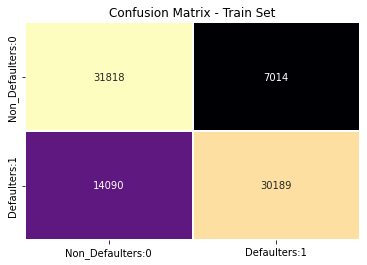

Train Set Scores


,Model,Accuracy,Precision,Recall,F1 Score,Cross_val_score
0,LogisticRegression,0.75,0.81,0.68,0.74,0.68


In [8]:
# Store the results for the train set
scores_train = []
scores_train.append({
    'Model': 'LogisticRegression',
    'Accuracy': round(accuracy_train, 2),
    'Precision': round(precision_train, 2),
    'Recall': round(recall_train, 2),
    'F1 Score': round(f1_train, 2),
    'Cross_val_score': round(cv_scores_train.mean(), 2)
})


# Confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_train = pd.DataFrame(cm_train, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set')
plt.show()

# Convert the results to DataFrames
scores_train_df = pd.DataFrame(scores_train)


print("Train Set Scores")
scores_train_df



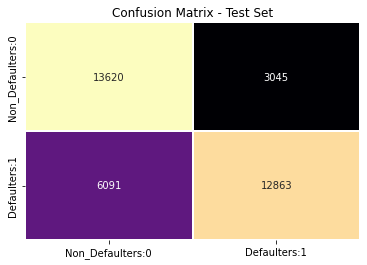

Test Set Scores


,Model,Accuracy,Precision,Recall,F1 Score,Cross_val_score
0,LogisticRegression,0.74,0.81,0.68,0.74,0.68


In [9]:
# Store the results for the test set
scores_test = []
scores_test.append({
    'Model': 'LogisticRegression',
    'Accuracy': round(accuracy_test, 2),
    'Precision': round(precision_test, 2),
    'Recall': round(recall_test, 2),
    'F1 Score': round(f1_test, 2),
    'Cross_val_score': round(cv_scores_test.mean(), 2)
})

# Confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)
conf_matrix_test = pd.DataFrame(cm_test, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set')
plt.show()

scores_test_df = pd.DataFrame(scores_test)

print("Test Set Scores")
scores_test_df

In [10]:
from sklearn.naive_bayes import GaussianNB

# Fit the Naive Bayes model
nb_model = GaussianNB().fit(X_train, y_train)

# Predictions for the test set
y_pred_test_nb = nb_model.predict(X_test)

# Predictions for the train set
y_pred_train_nb = nb_model.predict(X_train)

# Calculate scores for the test set
accuracy_test_nb = accuracy_score(y_test, y_pred_test_nb)
precision_test_nb = precision_score(y_test, y_pred_test_nb)
recall_test_nb = recall_score(y_test, y_pred_test_nb)
f1_test_nb = f1_score(y_test, y_pred_test_nb)
cv_scores_test_nb = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train_nb = accuracy_score(y_train, y_pred_train_nb)
precision_train_nb = precision_score(y_train, y_pred_train_nb)
recall_train_nb = recall_score(y_train, y_pred_train_nb)
f1_train_nb = f1_score(y_train, y_pred_train_nb)
cv_scores_train_nb = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='recall')


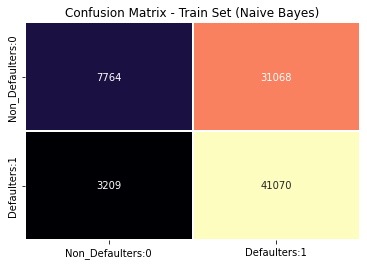

Train Set Scores - Naive Bayes
        Model  Accuracy  Precision  Recall  F1 Score  Cross_val_score
0  NaiveBayes      0.59       0.57    0.93      0.71             0.85


In [11]:
# Store the results for the train set
scores_train_nb = [{
    'Model': 'NaiveBayes',
    'Accuracy': round(accuracy_train_nb, 2),
    'Precision': round(precision_train_nb, 2),
    'Recall': round(recall_train_nb, 2),
    'F1 Score': round(f1_train_nb, 2),
    'Cross_val_score': round(cv_scores_train_nb.mean(), 2)
}]

# Confusion matrix for the train set
cm_train_nb = confusion_matrix(y_train, y_pred_train_nb)
conf_matrix_train_nb = pd.DataFrame(cm_train_nb, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train_nb, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set (Naive Bayes)')
plt.show()

# Convert the results to DataFrames
scores_train_nb_df = pd.DataFrame(scores_train_nb)

print("Train Set Scores - Naive Bayes")
print(scores_train_nb_df)


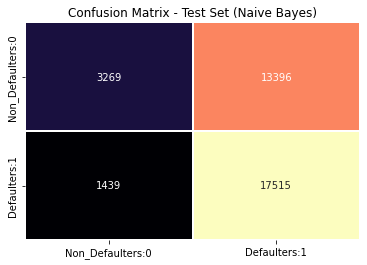

Test Set Scores - Naive Bayes
        Model  Accuracy  Precision  Recall  F1 Score  Cross_val_score
0  NaiveBayes      0.58       0.57    0.92       0.7             0.85


In [12]:
# Store the results for the test set
scores_test_nb = [{
    'Model': 'NaiveBayes',
    'Accuracy': round(accuracy_test_nb, 2),
    'Precision': round(precision_test_nb, 2),
    'Recall': round(recall_test_nb, 2),
    'F1 Score': round(f1_test_nb, 2),
    'Cross_val_score': round(cv_scores_test_nb.mean(), 2)
}]

# Confusion matrix for the test set
cm_test_nb = confusion_matrix(y_test, y_pred_test_nb)
conf_matrix_test_nb = pd.DataFrame(cm_test_nb, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test_nb, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set (Naive Bayes)')
plt.show()

scores_test_nb_df = pd.DataFrame(scores_test_nb)

print("Test Set Scores - Naive Bayes")
print(scores_test_nb_df)

In [13]:
# Fit the KNN model
knn_model = KNeighborsClassifier().fit(X_train, y_train)

# Predictions for the test set
y_pred_test_knn = knn_model.predict(X_test)

# Predictions for the train set
y_pred_train_knn = knn_model.predict(X_train)

# Calculate scores for the test set
accuracy_test_knn = accuracy_score(y_test, y_pred_test_knn)
precision_test_knn = precision_score(y_test, y_pred_test_knn)
recall_test_knn = recall_score(y_test, y_pred_test_knn)
f1_test_knn = f1_score(y_test, y_pred_test_knn)
cv_scores_test_knn = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train_knn = accuracy_score(y_train, y_pred_train_knn)
precision_train_knn = precision_score(y_train, y_pred_train_knn)
recall_train_knn = recall_score(y_train, y_pred_train_knn)
f1_train_knn = f1_score(y_train, y_pred_train_knn)
cv_scores_train_knn = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='recall')


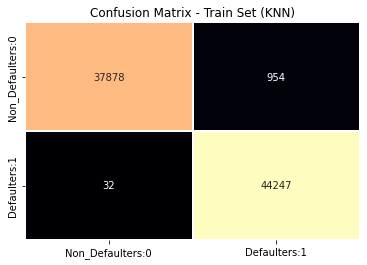

Train Set Scores - KNN
                  Model  Accuracy  Precision  Recall  F1 Score  \
0  KNeighborsClassifier      0.99       0.98     1.0      0.99   

   Cross_val_score  
0              1.0  


In [14]:
# Store the results for the train set
scores_train_knn = [{
    'Model': 'KNeighborsClassifier',
    'Accuracy': round(accuracy_train_knn, 2),
    'Precision': round(precision_train_knn, 2),
    'Recall': round(recall_train_knn, 2),
    'F1 Score': round(f1_train_knn, 2),
    'Cross_val_score': round(cv_scores_train_knn.mean(), 2)
}]

# Confusion matrix for the train set
cm_train_knn = confusion_matrix(y_train, y_pred_train_knn)
conf_matrix_train_knn = pd.DataFrame(cm_train_knn, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train_knn, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set (KNN)')
plt.show()

# Convert the results to DataFrames
scores_train_knn_df = pd.DataFrame(scores_train_knn)

print("Train Set Scores - KNN")
print(scores_train_knn_df)


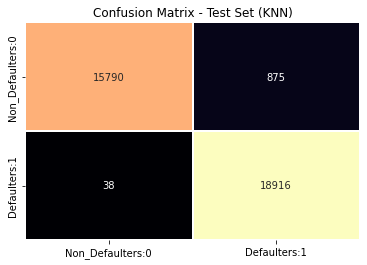

Test Set Scores - KNN
                  Model  Accuracy  Precision  Recall  F1 Score  \
0  KNeighborsClassifier      0.97       0.96     1.0      0.98   

   Cross_val_score  
0              1.0  


In [15]:
# Store the results for the test set
scores_test_knn = [{
    'Model': 'KNeighborsClassifier',
    'Accuracy': round(accuracy_test_knn, 2),
    'Precision': round(precision_test_knn, 2),
    'Recall': round(recall_test_knn, 2),
    'F1 Score': round(f1_test_knn, 2),
    'Cross_val_score': round(cv_scores_test_knn.mean(), 2)
}]

# Confusion matrix for the test set
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)
conf_matrix_test_knn = pd.DataFrame(cm_test_knn, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test_knn, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set (KNN)')
plt.show()

scores_test_knn_df = pd.DataFrame(scores_test_knn)

print("Test Set Scores - KNN")
print(scores_test_knn_df)


In [16]:
# Fit the Decision Tree model
dt_model = DecisionTreeClassifier().fit(X_train, y_train)

# Predictions for the test set
y_pred_test_dt = dt_model.predict(X_test)

# Predictions for the train set
y_pred_train_dt = dt_model.predict(X_train)

# Calculate scores for the test set
accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)
precision_test_dt = precision_score(y_test, y_pred_test_dt)
recall_test_dt = recall_score(y_test, y_pred_test_dt)
f1_test_dt = f1_score(y_test, y_pred_test_dt)
cv_scores_test_dt = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
precision_train_dt = precision_score(y_train, y_pred_train_dt)
recall_train_dt = recall_score(y_train, y_pred_train_dt)
f1_train_dt = f1_score(y_train, y_pred_train_dt)
cv_scores_train_dt = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='recall')

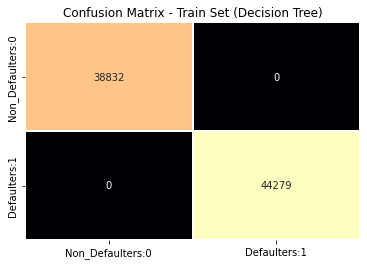

Train Set Scores - Decision Tree
                    Model  Accuracy  Precision  Recall  F1 Score  \
0  DecisionTreeClassifier       1.0        1.0     1.0       1.0   

   Cross_val_score  
0             0.97  


In [17]:
# Store the results for the train set
scores_train_dt = [{
    'Model': 'DecisionTreeClassifier',
    'Accuracy': round(accuracy_train_dt, 2),
    'Precision': round(precision_train_dt, 2),
    'Recall': round(recall_train_dt, 2),
    'F1 Score': round(f1_train_dt, 2),
    'Cross_val_score': round(cv_scores_train_dt.mean(), 2)
}]

# Confusion matrix for the train set
cm_train_dt = confusion_matrix(y_train, y_pred_train_dt)
conf_matrix_train_dt = pd.DataFrame(cm_train_dt, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train_dt, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set (Decision Tree)')
plt.show()

# Convert the results to DataFrames
scores_train_dt_df = pd.DataFrame(scores_train_dt)

print("Train Set Scores - Decision Tree")
print(scores_train_dt_df)


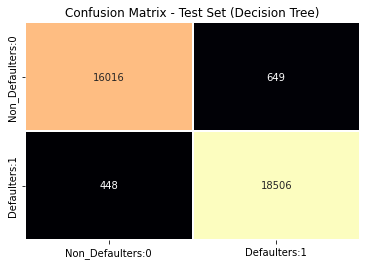

Test Set Scores - Decision Tree
                    Model  Accuracy  Precision  Recall  F1 Score  \
0  DecisionTreeClassifier      0.97       0.97    0.98      0.97   

   Cross_val_score  
0             0.97  


In [18]:
# Store the results for the test set
scores_test_dt = [{
    'Model': 'DecisionTreeClassifier',
    'Accuracy': round(accuracy_test_dt, 2),
    'Precision': round(precision_test_dt, 2),
    'Recall': round(recall_test_dt, 2),
    'F1 Score': round(f1_test_dt, 2),
    'Cross_val_score': round(cv_scores_test_dt.mean(), 2)
}]

# Confusion matrix for the test set
cm_test_dt = confusion_matrix(y_test, y_pred_test_dt)
conf_matrix_test_dt = pd.DataFrame(cm_test_dt, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test_dt, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set (Decision Tree)')
plt.show()

scores_test_dt_df = pd.DataFrame(scores_test_dt)

print("Test Set Scores - Decision Tree")
print(scores_test_dt_df)


In [19]:
# Fit the Random Forest model
rf_model = RandomForestClassifier().fit(X_train, y_train)

# Predictions for the test set
y_pred_test_rf = rf_model.predict(X_test)

# Predictions for the train set
y_pred_train_rf = rf_model.predict(X_train)

# Calculate scores for the test set
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
precision_test_rf = precision_score(y_test, y_pred_test_rf)
recall_test_rf = recall_score(y_test, y_pred_test_rf)
f1_test_rf = f1_score(y_test, y_pred_test_rf)
cv_scores_test_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
precision_train_rf = precision_score(y_train, y_pred_train_rf)
recall_train_rf = recall_score(y_train, y_pred_train_rf)
f1_train_rf = f1_score(y_train, y_pred_train_rf)
cv_scores_train_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='recall')

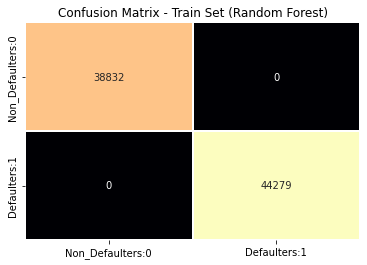

Train Set Scores - Random Forest
                    Model  Accuracy  Precision  Recall  F1 Score  \
0  RandomForestClassifier       1.0        1.0     1.0       1.0   

   Cross_val_score  
0             0.99  


In [20]:
# Store the results for the train set
scores_train_rf = [{
    'Model': 'RandomForestClassifier',
    'Accuracy': round(accuracy_train_rf, 2),
    'Precision': round(precision_train_rf, 2),
    'Recall': round(recall_train_rf, 2),
    'F1 Score': round(f1_train_rf, 2),
    'Cross_val_score': round(cv_scores_train_rf.mean(), 2)
}]

# Confusion matrix for the train set
cm_train_rf = confusion_matrix(y_train, y_pred_train_rf)
conf_matrix_train_rf = pd.DataFrame(cm_train_rf, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train_rf, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set (Random Forest)')
plt.show()

# Convert the results to DataFrames
scores_train_rf_df = pd.DataFrame(scores_train_rf)

print("Train Set Scores - Random Forest")
print(scores_train_rf_df)

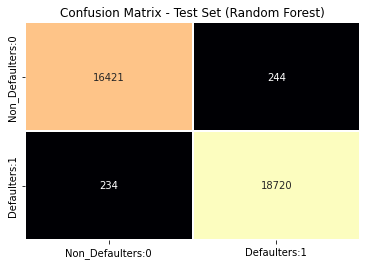

Test Set Scores - Random Forest
                    Model  Accuracy  Precision  Recall  F1 Score  \
0  RandomForestClassifier      0.99       0.99    0.99      0.99   

   Cross_val_score  
0             0.99  


In [21]:
# Store the results for the test set
scores_test_rf = [{
    'Model': 'RandomForestClassifier',
    'Accuracy': round(accuracy_test_rf, 2),
    'Precision': round(precision_test_rf, 2),
    'Recall': round(recall_test_rf, 2),
    'F1 Score': round(f1_test_rf, 2),
    'Cross_val_score': round(cv_scores_test_rf.mean(), 2)
}]

# Confusion matrix for the test set
cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)
conf_matrix_test_rf = pd.DataFrame(cm_test_rf, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test_rf, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set (Random Forest)')
plt.show()

scores_test_rf_df = pd.DataFrame(scores_test_rf)

print("Test Set Scores - Random Forest")
print(scores_test_rf_df)


In [22]:
# Fit the AdaBoost model
ada_model = AdaBoostClassifier().fit(X_train, y_train)

# Predictions for the test set
y_pred_test_ada = ada_model.predict(X_test)

# Predictions for the train set
y_pred_train_ada = ada_model.predict(X_train)

# Calculate scores for the test set
accuracy_test_ada = accuracy_score(y_test, y_pred_test_ada)
precision_test_ada = precision_score(y_test, y_pred_test_ada)
recall_test_ada = recall_score(y_test, y_pred_test_ada)
f1_test_ada = f1_score(y_test, y_pred_test_ada)
cv_scores_test_ada = cross_val_score(ada_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train_ada = accuracy_score(y_train, y_pred_train_ada)
precision_train_ada = precision_score(y_train, y_pred_train_ada)
recall_train_ada = recall_score(y_train, y_pred_train_ada)
f1_train_ada = f1_score(y_train, y_pred_train_ada)
cv_scores_train_ada = cross_val_score(ada_model, X_train, y_train, cv=5, scoring='recall')


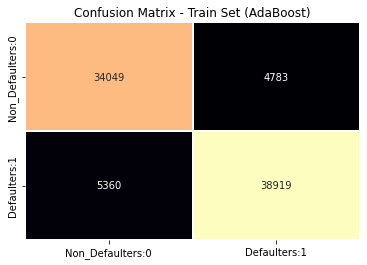

Train Set Scores - AdaBoost
                Model  Accuracy  Precision  Recall  F1 Score  Cross_val_score
0  AdaBoostClassifier      0.88       0.89    0.88      0.88             0.88


In [23]:
# Store the results for the train set
scores_train_ada = [{
    'Model': 'AdaBoostClassifier',
    'Accuracy': round(accuracy_train_ada, 2),
    'Precision': round(precision_train_ada, 2),
    'Recall': round(recall_train_ada, 2),
    'F1 Score': round(f1_train_ada, 2),
    'Cross_val_score': round(cv_scores_train_ada.mean(), 2)
}]

# Confusion matrix for the train set
cm_train_ada = confusion_matrix(y_train, y_pred_train_ada)
conf_matrix_train_ada = pd.DataFrame(cm_train_ada, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train_ada, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set (AdaBoost)')
plt.show()

# Convert the results to DataFrames
scores_train_ada_df = pd.DataFrame(scores_train_ada)

print("Train Set Scores - AdaBoost")
print(scores_train_ada_df)


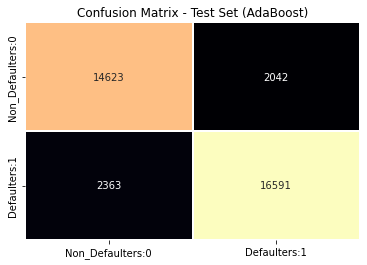

Test Set Scores - AdaBoost
                Model  Accuracy  Precision  Recall  F1 Score  Cross_val_score
0  AdaBoostClassifier      0.88       0.89    0.88      0.88             0.88


In [24]:
# Store the results for the test set
scores_test_ada = [{
    'Model': 'AdaBoostClassifier',
    'Accuracy': round(accuracy_test_ada, 2),
    'Precision': round(precision_test_ada, 2),
    'Recall': round(recall_test_ada, 2),
    'F1 Score': round(f1_test_ada, 2),
    'Cross_val_score': round(cv_scores_test_ada.mean(), 2)
}]

# Confusion matrix for the test set
cm_test_ada = confusion_matrix(y_test, y_pred_test_ada)
conf_matrix_test_ada = pd.DataFrame(cm_test_ada, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test_ada, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set (AdaBoost)')
plt.show()

scores_test_ada_df = pd.DataFrame(scores_test_ada)

print("Test Set Scores - AdaBoost")
print(scores_test_ada_df)


In [25]:
# Fit the Gradient Boosting model
gbm_model = GradientBoostingClassifier().fit(X_train, y_train)

# Predictions for the test set
y_pred_test_gbm = gbm_model.predict(X_test)

# Predictions for the train set
y_pred_train_gbm = gbm_model.predict(X_train)

# Calculate scores for the test set
accuracy_test_gbm = accuracy_score(y_test, y_pred_test_gbm)
precision_test_gbm = precision_score(y_test, y_pred_test_gbm)
recall_test_gbm = recall_score(y_test, y_pred_test_gbm)
f1_test_gbm = f1_score(y_test, y_pred_test_gbm)
cv_scores_test_gbm = cross_val_score(gbm_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train_gbm = accuracy_score(y_train, y_pred_train_gbm)
precision_train_gbm = precision_score(y_train, y_pred_train_gbm)
recall_train_gbm = recall_score(y_train, y_pred_train_gbm)
f1_train_gbm = f1_score(y_train, y_pred_train_gbm)
cv_scores_train_gbm = cross_val_score(gbm_model, X_train, y_train, cv=5, scoring='recall')

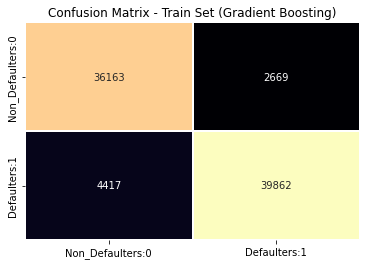

Train Set Scores - Gradient Boosting
                        Model  Accuracy  Precision  Recall  F1 Score  \
0  GradientBoostingClassifier      0.91       0.94     0.9      0.92   

   Cross_val_score  
0              0.9  


In [26]:
# Store the results for the train set
scores_train_gbm = [{
    'Model': 'GradientBoostingClassifier',
    'Accuracy': round(accuracy_train_gbm, 2),
    'Precision': round(precision_train_gbm, 2),
    'Recall': round(recall_train_gbm, 2),
    'F1 Score': round(f1_train_gbm, 2),
    'Cross_val_score': round(cv_scores_train_gbm.mean(), 2)
}]

# Confusion matrix for the train set
cm_train_gbm = confusion_matrix(y_train, y_pred_train_gbm)
conf_matrix_train_gbm = pd.DataFrame(cm_train_gbm, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train_gbm, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set (Gradient Boosting)')
plt.show()

# Convert the results to DataFrames
scores_train_gbm_df = pd.DataFrame(scores_train_gbm)

print("Train Set Scores - Gradient Boosting")
print(scores_train_gbm_df)

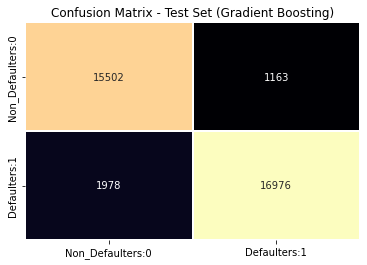

Test Set Scores - Gradient Boosting
                        Model  Accuracy  Precision  Recall  F1 Score  \
0  GradientBoostingClassifier      0.91       0.94     0.9      0.92   

   Cross_val_score  
0              0.9  


In [27]:
# Store the results for the test set
scores_test_gbm = [{
    'Model': 'GradientBoostingClassifier',
    'Accuracy': round(accuracy_test_gbm, 2),
    'Precision': round(precision_test_gbm, 2),
    'Recall': round(recall_test_gbm, 2),
    'F1 Score': round(f1_test_gbm, 2),
    'Cross_val_score': round(cv_scores_test_gbm.mean(), 2)
}]

# Confusion matrix for the test set
cm_test_gbm = confusion_matrix(y_test, y_pred_test_gbm)
conf_matrix_test_gbm = pd.DataFrame(cm_test_gbm, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test_gbm, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set (Gradient Boosting)')
plt.show()

scores_test_gbm_df = pd.DataFrame(scores_test_gbm)

print("Test Set Scores - Gradient Boosting")
print(scores_test_gbm_df)


In [28]:
# Fit the XGBoost model
xgb_model = XGBClassifier().fit(X_train, y_train)

# Predictions for the test set
y_pred_test_xgb = xgb_model.predict(X_test)

# Predictions for the train set
y_pred_train_xgb = xgb_model.predict(X_train)

# Calculate scores for the test set
accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)
precision_test_xgb = precision_score(y_test, y_pred_test_xgb)
recall_test_xgb = recall_score(y_test, y_pred_test_xgb)
f1_test_xgb = f1_score(y_test, y_pred_test_xgb)
cv_scores_test_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='recall')

# Calculate scores for the train set
accuracy_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
precision_train_xgb = precision_score(y_train, y_pred_train_xgb)
recall_train_xgb = recall_score(y_train, y_pred_train_xgb)
f1_train_xgb = f1_score(y_train, y_pred_train_xgb)
cv_scores_train_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='recall')


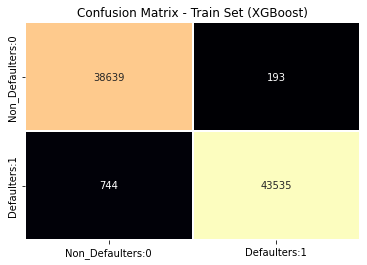

Train Set Scores - XGBoost
           Model  Accuracy  Precision  Recall  F1 Score  Cross_val_score
0  XGBClassifier      0.99        1.0    0.98      0.99             0.98


In [29]:
# Store the results for the train set
scores_train_xgb = [{
    'Model': 'XGBClassifier',
    'Accuracy': round(accuracy_train_xgb, 2),
    'Precision': round(precision_train_xgb, 2),
    'Recall': round(recall_train_xgb, 2),
    'F1 Score': round(f1_train_xgb, 2),
    'Cross_val_score': round(cv_scores_train_xgb.mean(), 2)
}]

# Confusion matrix for the train set
cm_train_xgb = confusion_matrix(y_train, y_pred_train_xgb)
conf_matrix_train_xgb = pd.DataFrame(cm_train_xgb, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_train_xgb, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Train Set (XGBoost)')
plt.show()

# Convert the results to DataFrames
scores_train_xgb_df = pd.DataFrame(scores_train_xgb)

print("Train Set Scores - XGBoost")
print(scores_train_xgb_df)

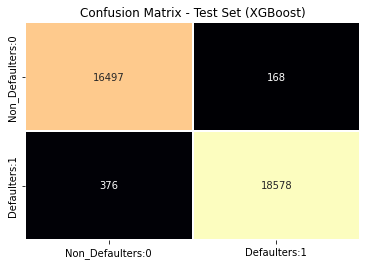

Test Set Scores - XGBoost
           Model  Accuracy  Precision  Recall  F1 Score  Cross_val_score
0  XGBClassifier      0.98       0.99    0.98      0.99             0.98


In [30]:
# Store the results for the test set
scores_test_xgb = [{
    'Model': 'XGBClassifier',
    'Accuracy': round(accuracy_test_xgb, 2),
    'Precision': round(precision_test_xgb, 2),
    'Recall': round(recall_test_xgb, 2),
    'F1 Score': round(f1_test_xgb, 2),
    'Cross_val_score': round(cv_scores_test_xgb.mean(), 2)
}]

# Confusion matrix for the test set
cm_test_xgb = confusion_matrix(y_test, y_pred_test_xgb)
conf_matrix_test_xgb = pd.DataFrame(cm_test_xgb, columns=['Non_Defaulters:0', 'Defaulters:1'], index=['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix_test_xgb, annot=True, fmt='d', cmap='magma', cbar=False, linewidth=0.2)
plt.title('Confusion Matrix - Test Set (XGBoost)')
plt.show()

scores_test_xgb_df = pd.DataFrame(scores_test_xgb)

print("Test Set Scores - XGBoost")
print(scores_test_xgb_df)

In [31]:
train_scores = pd.concat([scores_train_df, scores_train_nb_df, scores_train_knn_df, scores_train_dt_df, scores_train_rf_df, scores_train_ada_df, scores_train_gbm_df, scores_train_xgb_df])
train_scores.sort_values(by = 'Recall', ascending = False)

,Model,Accuracy,Precision,Recall,F1 Score,Cross_val_score
0,KNeighborsClassifier,0.99,0.98,1.00,0.99,1.00
0,DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.97
0,RandomForestClassifier,1.00,1.00,1.00,1.00,0.99
0,XGBClassifier,0.99,1.00,0.98,0.99,0.98
0,NaiveBayes,0.59,0.57,0.93,0.71,0.85
0,GradientBoostingClassifier,0.91,0.94,0.90,0.92,0.90
0,AdaBoostClassifier,0.88,0.89,0.88,0.88,0.88
0,LogisticRegression,0.75,0.81,0.68,0.74,0.68


In [32]:
test_scores = pd.concat([scores_test_df, scores_test_nb_df, scores_test_knn_df, scores_test_dt_df, scores_test_rf_df, scores_test_ada_df, scores_test_gbm_df, scores_test_xgb_df])
test_scores.sort_values(by = 'Recall', ascending = False)

,Model,Accuracy,Precision,Recall,F1 Score,Cross_val_score
0,KNeighborsClassifier,0.97,0.96,1.00,0.98,1.00
0,RandomForestClassifier,0.99,0.99,0.99,0.99,0.99
0,DecisionTreeClassifier,0.97,0.97,0.98,0.97,0.97
0,XGBClassifier,0.98,0.99,0.98,0.99,0.98
0,NaiveBayes,0.58,0.57,0.92,0.70,0.85
0,GradientBoostingClassifier,0.91,0.94,0.90,0.92,0.90
0,AdaBoostClassifier,0.88,0.89,0.88,0.88,0.88
0,LogisticRegression,0.74,0.81,0.68,0.74,0.68


# <font color = 'green'>Hyper Parameter Tuning

In [14]:
tune_param = [{'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'metric' : ['euclidean', 'manhattan'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree']}]

knn_model = KNeighborsClassifier()
grid_knn = GridSearchCV(estimator = knn_model, param_grid = tune_param, cv = 5, scoring = 'recall').fit(X_train, y_train)
print('Best Hyper Parameters for KNN Classifier are :',grid_knn.best_params_,'\n')

KeyboardInterrupt: 

In [ ]:
knn_hyp_model = KNeighborsClassifier().fit(X_train, y_train)
y_pred_knn = knn_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
cross_val = cross_val_score(knn_hyp_model, X_train, y_train, cv = 5, scoring = 'recall')  

hyp_scores = []

hyp_scores.append({
    'Model' : 'KNeighborsClassifier',
    'Accuracy' : round(accuracy,2),
    'Precision' : round(precision,2),
    'Recall' : round(recall,2),
    'F1 Score' : round(f1,2),
    'Cross_val_score' : round(cv_scores.mean(),2)
})

cm = confusion_matrix(y_test, y_pred_knn)
conf_matrix = pd.DataFrame(cm, columns = ['Non_Defaulters:0', 'Defaulters:1'], index = ['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'magma', cbar = False, linewidth = 0.2)
plt.show()

hyp_scores_df = pd.DataFrame(hyp_scores)
hyp_scores_df

In [ ]:
tune_param_dt = {
    'max_depth': [10, 20, 30],  # Added None for no limit
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],  # Added None for no limit
    'criterion': ['gini', 'entropy'],  # Including criterion parameter
    'splitter': ['best', 'random']  # Including splitter parameter
}

dt_model = DecisionTreeClassifier()
grid_dt = GridSearchCV(estimator=dt_model, param_grid=tune_param_dt, cv=5, scoring='recall').fit(X_train, y_train)
print('Best Hyper Parameters for Decision Tree Classifier are:', grid_dt.best_params_, '\n')

In [ ]:
dt_hyp_model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt = dt_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
cross_val = cross_val_score(dt_hyp_model, X_train, y_train, cv = 5, scoring = 'recall')  

hyp_scores = []

hyp_scores.append({
    'Model' : 'DecisionTreeClassifier',
    'Accuracy' : round(accuracy,2),
    'Precision' : round(precision,2),
    'Recall' : round(recall,2),
    'F1 Score' : round(f1,2),
    'Cross_val_score' : round(cv_scores.mean(),2)
})

cm = confusion_matrix(y_test, y_pred_dt)
conf_matrix = pd.DataFrame(cm, columns = ['Non_Defaulters:0', 'Defaulters:1'], index = ['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'magma', cbar = False, linewidth = 0.2)
plt.show()

hyp_scores_df1 = pd.DataFrame(hyp_scores)
hyp_scores_df = pd.concat([hyp_scores_df1, hyp_scores_df])
hyp_scores_df

In [ ]:
tune_param_rf = [{
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False],  
    'criterion': ['gini', 'entropy']
}]

rf_model = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rf_model, param_grid=tune_param_rf, cv=5, scoring='recall').fit(X_train, y_train)
print('Best Hyper Parameters for Random Forest Classifier are:', grid_rf.best_params_, '\n')

In [ ]:
rf_hyp_model = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = rf_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
cross_val = cross_val_score(rf_hyp_model, X_train, y_train, cv = 5, scoring = 'recall')  

hyp_scores = []

hyp_scores.append({
    'Model' : 'RandomForestClassifier',
    'Accuracy' : round(accuracy,2),
    'Precision' : round(precision,2),
    'Recall' : round(recall,2),
    'F1 Score' : round(f1,2),
    'Cross_val_score' : round(cv_scores.mean(),2)
})

cm = confusion_matrix(y_test, y_pred_rf)
conf_matrix = pd.DataFrame(cm, columns = ['Non_Defaulters:0', 'Defaulters:1'], index = ['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'magma', cbar = False, linewidth = 0.2)
plt.show()

hyp_scores_df2 = pd.DataFrame(hyp_scores)
hyp_scores_df = pd.concat([hyp_scores_df2, hyp_scores_df])
hyp_scores_df

In [ ]:
tune_param_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R'],
    'base_estimator__max_depth': [1, 2, 3, 4],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4],
    'base_estimator__max_features': ['auto', 'sqrt', 'log2', None],
    'base_estimator__criterion': ['gini', 'entropy'],
    'base_estimator__splitter': ['best', 'random']
}

ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
grid_ada = GridSearchCV(estimator=ada_model, param_grid=tune_param_ada, cv=5, scoring='recall').fit(X_train, y_train)
print('Best Hyper Parameters for AdaBoost Classifier are:', grid_ada.best_params_, '\n')

In [ ]:
ada_hyp_model = AdaBoostClassifier().fit(X_train, y_train)
y_pred_ada = ada_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_ada)
recall = recall_score(y_test, y_pred_ada)
precision = precision_score(y_test, y_pred_ada)
f1 = f1_score(y_test, y_pred_ada)
cross_val = cross_val_score(ada_hyp_model, X_train, y_train, cv = 5, scoring = 'recall')  

hyp_scores = []

hyp_scores.append({
    'Model' : 'AdaBoostClassifier',
    'Accuracy' : round(accuracy,2),
    'Precision' : round(precision,2),
    'Recall' : round(recall,2),
    'F1 Score' : round(f1,2),
    'Cross_val_score' : round(cv_scores.mean(),2)
})

cm = confusion_matrix(y_test, y_pred_ada)
conf_matrix = pd.DataFrame(cm, columns = ['Non_Defaulters:0', 'Defaulters:1'], index = ['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'magma', cbar = False, linewidth = 0.2)
plt.show()

hyp_scores_df3 = pd.DataFrame(hyp_scores)
hyp_scores_df = pd.concat([hyp_scores_df3, hyp_scores_df])
hyp_scores_df

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

tune_param_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'loss': ['deviance', 'exponential']  # Including loss parameter
}

gb_model = GradientBoostingClassifier()
grid_gb = GridSearchCV(estimator=gb_model, param_grid=tune_param_gb, cv=5, scoring='recall').fit(X_train, y_train)
print('Best Hyper Parameters for Gradient Boosting Classifier are:', grid_gb.best_params_, '\n')

In [ ]:
gbm_hyp_model = GradientBoostingClassifier().fit(X_train, y_train)
y_pred_gbm = gbm_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gbm)
recall = recall_score(y_test, y_pred_gbm)
precision = precision_score(y_test, y_pred_gbm)
f1 = f1_score(y_test, y_pred_gbm)
cross_val = cross_val_score(gbm_hyp_model, X_train, y_train, cv = 5, scoring = 'recall')  

hyp_scores = []

hyp_scores.append({
    'Model' : 'GradientBoostingClassifier',
    'Accuracy' : round(accuracy,2),
    'Precision' : round(precision,2),
    'Recall' : round(recall,2),
    'F1 Score' : round(f1,2),
    'Cross_val_score' : round(cv_scores.mean(),2)
})

cm = confusion_matrix(y_test, y_pred_gbm)
conf_matrix = pd.DataFrame(cm, columns = ['Non_Defaulters:0', 'Defaulters:1'], index = ['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'magma', cbar = False, linewidth = 0.2)
plt.show()

hyp_scores_df4 = pd.DataFrame(hyp_scores)
hyp_scores_df = pd.concat([hyp_scores_df4, hyp_scores_df])
hyp_scores_df

In [ ]:
from xgboost import XGBClassifier

tune_param_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 0.1, 0.01],
    'scale_pos_weight': [1, 3, 5]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=tune_param_xgb, cv=5, scoring='recall').fit(X_train, y_train)
print('Best Hyper Parameters for XGBoost Classifier are:', grid_xgb.best_params_, '\n')

In [ ]:
xgb_hyp_model = XGBClassifier().fit(X_train, y_train)
y_pred_xgb = xgb_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
cross_val = cross_val_score(xgb_hyp_model, X_train, y_train, cv = 5, scoring = 'recall')  

hyp_scores = []

hyp_scores.append({
    'Model' : 'XGBClassifier',
    'Accuracy' : round(accuracy,2),
    'Precision' : round(precision,2),
    'Recall' : round(recall,2),
    'F1 Score' : round(f1,2),
    'Cross_val_score' : round(cv_scores.mean(),2)
})

cm = confusion_matrix(y_test, y_pred_xgb)
conf_matrix = pd.DataFrame(cm, columns = ['Non_Defaulters:0', 'Defaulters:1'], index = ['Non_Defaulters:0', 'Defaulters:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'magma', cbar = False, linewidth = 0.2)
plt.show()

hyp_scores_df5 = pd.DataFrame(hyp_scores)
hyp_scores_df = pd.concat([hyp_scores_df5, hyp_scores_df])
hyp_scores_df